In [1]:
# Pacotes
import pandas as pd
import numpy as np
import pmdarima as pm
from pmdarima import model_selection

In [2]:
# Data
df = pd.read_csv('./SERIES/C91-95 - LEUCEMIA.csv', sep=';',  encoding='ISO-8859-1', header=1)
# Separação em treino validação e teste
train, test = model_selection.train_test_split(np.array(df['OBITO_CANCER'].values), train_size=0.8)

In [3]:
# # Teste de estacionariedade
# from statsmodels.tsa.stattools import adfuller

# result = adfuller(train)
# print('Estatística ADF:', result[0])
# print('p-valor:', result[1])


In [9]:
# Even though we have a dedicated train/test split, we can (and should) still
# use cross-validation on our training set to get a good estimate of the model
# performance. We can choose which model is better based on how it performs
# over various folds.
model1 = pm.ARIMA(order=(2, 1, 1))
model2 = pm.ARIMA(order=(1, 1, 2),
                  seasonal_order=(0, 1, 1, 12),
                  suppress_warnings=True)


In [10]:

cv = model_selection.SlidingWindowForecastCV(window_size=10, step=10, h=1)

model1_cv_scores = model_selection.cross_val_score(
    model1, train, scoring='smape', cv=cv, verbose=2)

model2_cv_scores = model_selection.cross_val_score(
    model2, train, scoring='smape', cv=cv, verbose=2)


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................


c:\Users\danttis\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\danttis\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\danttis\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\danttis\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................


c:\Users\danttis\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:

print("Model 1 CV scores: {}".format(model1_cv_scores.tolist()))
print("Model 2 CV scores: {}".format(model2_cv_scores.tolist()))


Model 1 CV scores: [3.74524962422051, 2.7075328425886265, 2.150177048087175]
Model 2 CV scores: [2.1633484872237028, 0.21299254526091588, 1.251303441084463]


In [12]:

# Pick based on which has a lower mean error rate
m1_average_error = np.average(model1_cv_scores)
m2_average_error = np.average(model2_cv_scores)
errors = [m1_average_error, m2_average_error]
models = [model1, model2]


In [13]:

# print out the answer
better_index = np.argmin(errors)  # type: int
print("Lowest average SMAPE: {} (model{})".format(
    errors[better_index], better_index + 1))
print("Best model: {}".format(models[better_index]))

Lowest average SMAPE: 1.2092148245230272 (model2)
Best model:  ARIMA(1,1,2)(0,1,1)[12] intercept


In [16]:
model2.fit(train)


ARIMA(order=(1, 1, 2), seasonal_order=(0, 1, 1, 12), suppress_warnings=True)

In [18]:
pred = model2.predict(n_periods=len(test))

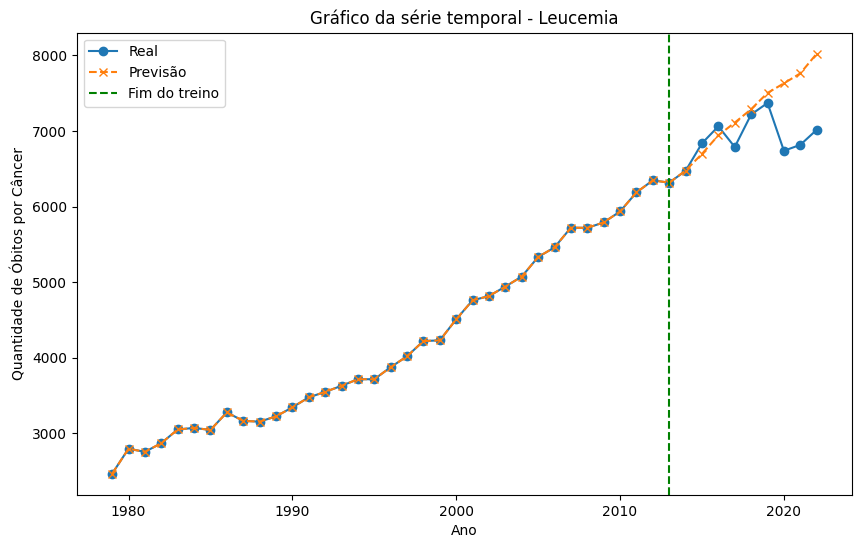

In [20]:
# Modelando
import matplotlib.pyplot as plt

anos = df['ANO']
obito_cancer_real = df['OBITO_CANCER']
plt.figure(figsize=(10, 6))
plt.plot(anos, obito_cancer_real, label='Real', marker='o')  
plt.plot(anos, list(train)+list(pred), label='Previsão', linestyle='--', marker='x')
plt.axvline(x=anos[len(train)-1], color='green', linestyle='--', label='Fim do treino')
plt.title(f'Gráfico da série temporal - Leucemia')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Óbitos por Câncer')
plt.legend()
plt.show()
